<a href="https://colab.research.google.com/github/karlacuv/MCD_Procesamiento/blob/main/ProyectoFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Conexión a Drive y Unzip de Imágenes

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/My Drive/Files/MCD/Procesamiento y Clasificación de Datos/Proyecto Final/archive.zip'

Streaming output truncated to the last 5000 lines.
  inflating: Human Action Recognition/train/Image_5499.jpg  
  inflating: Human Action Recognition/train/Image_55.jpg  
  inflating: Human Action Recognition/train/Image_550.jpg  
  inflating: Human Action Recognition/train/Image_5500.jpg  
  inflating: Human Action Recognition/train/Image_5501.jpg  
  inflating: Human Action Recognition/train/Image_5502.jpg  
  inflating: Human Action Recognition/train/Image_5503.jpg  
  inflating: Human Action Recognition/train/Image_5504.jpg  
  inflating: Human Action Recognition/train/Image_5505.jpg  
  inflating: Human Action Recognition/train/Image_5506.jpg  
  inflating: Human Action Recognition/train/Image_5507.jpg  
  inflating: Human Action Recognition/train/Image_5508.jpg  
  inflating: Human Action Recognition/train/Image_5509.jpg  
  inflating: Human Action Recognition/train/Image_551.jpg  
  inflating: Human Action Recognition/train/Image_5510.jpg  
  inflating: Human Action Recognition/

### Imports

In [ ]:
import os

import torch
from torch import nn, optim
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
from fastai.vision.all import *

import tensorflow as tf
from tensorflow import keras
import argparse
from imutils import paths

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np
import cv2
from glob import glob
import pandas as pd

sns.set_theme()

from tensorflow.keras import backend as K
from tensorflow.keras import utils as np_utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Conv2D, MaxPooling2D, ZeroPadding2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import  ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
from keras import regularizers
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

### Carga de Imágenes

In [ ]:
import shutil, os
import pandas as pd

#Read the labels from ground truth
df = pd.read_csv('Human Action Recognition/Training_set.csv', sep=",", names=['Filename','Class'], header=None, skiprows=1)

#Extract the labels and store in a new data frame called labels
labels = df.sort_values('Class')

#Create a Python list of Unique labels in data frame labels
class_names = list(labels.Class.unique())

#Creating a set of subfolders within folder test_ per each class

for i in class_names:
    os.makedirs(os.path.join('Data',i))


In [ ]:
for c in class_names:
    for i in list(labels[labels['Class']==c]['Filename']):

        #create path to the image 
        get_image = os.path.join('Human Action Recognition/train/',i)

        #If image has not already exist in the new folder create one        
        if not os.path.exists('Data/'+c+i):
            # move the image 
            move_image_to_cat = shutil.move(get_image,'Data/'+c)

In [ ]:
!pip install split-folders
import splitfolders
splitfolders.ratio('Data', output="Data_", seed=1337, ratio=(.8, 0.1,0.1)) 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying files: 12600 files [00:02, 5498.55 files/s]


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.3, 
                             horizontal_flip=True)
test_datagen=ImageDataGenerator()

train_data=datagen.flow_from_directory('Data_/train',batch_size=64,
                                    target_size=(160,160),
                                    shuffle=True,
                                    color_mode="rgb",class_mode='categorical')

validation_data=datagen.flow_from_directory('Data_/val',batch_size=64,
                                    target_size=(160,160),
                                    shuffle=True,
                                    color_mode="rgb",class_mode='categorical')

test_data=test_datagen.flow_from_directory('Data_/test',batch_size=64,
                                    target_size=(160,160),
                                    shuffle=False,
                                    color_mode="rgb",class_mode='categorical')

Found 10080 images belonging to 15 classes.
Found 1260 images belonging to 15 classes.
Found 1260 images belonging to 15 classes.


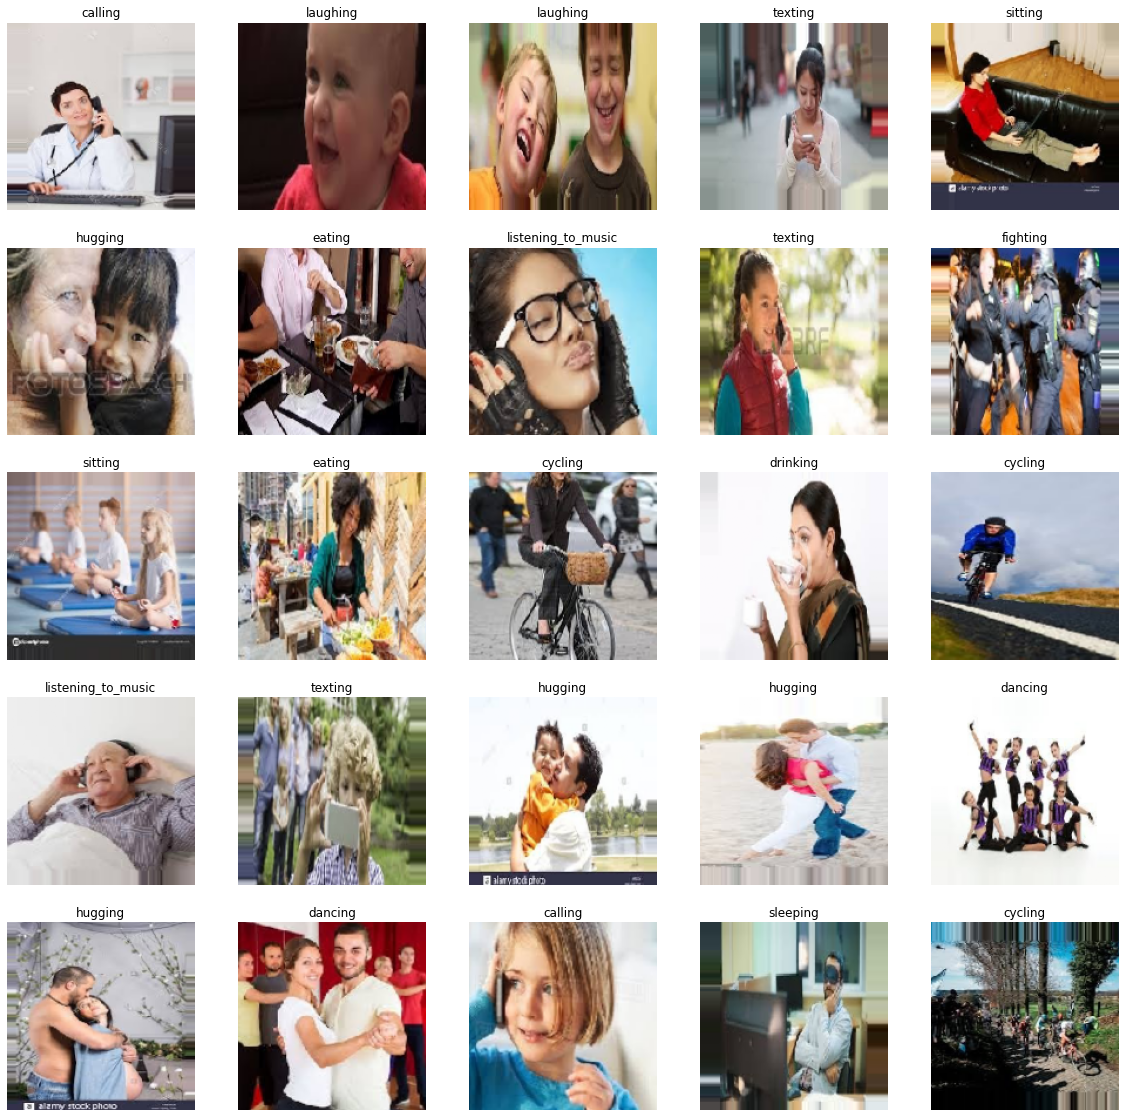

In [ ]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image=images[i] /255       
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='black', fontsize=12)
        plt.axis('off')
    plt.show()
    
show_image_samples(train_data)

### Modelo

In [ ]:
#Callbacks
Learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                             mode='auto',
                                            cooldown=1 )
Early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                                  min_delta=0.001,
                                                  patience = 5,
                                                  verbose = 1,
                                                  restore_best_weights=True)
# Create base model (load the pre-trained model)
base_model_EfficientNetB0 = tf.keras.applications.EfficientNetB0(include_top=False)

# Freeze the base model (pre-trained patterns aren't update during training)
base_model_EfficientNetB0.trainable = False

# Create inputs 
inputs = tf.keras.layers.Input(shape=(160,160,3), name="input_layer")

# Pass the inputs to the base model
x = base_model_EfficientNetB0(inputs)

# Average pooling the outputs of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Create output activation layer
outputs = tf.keras.layers.Dense(15,activation="softmax", name="output_layer")(x)

# Combine the inputs with the outputs into a model
model_1 = tf.keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
               metrics=["accuracy"])

model_1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 160, 160, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 15)                19215     
                                                                 
Total params: 4,068,786
Trainable params: 19,215
Non-trainable params: 4,049,571
_________________________________________________________________


### Entrenamiento del Modelo

In [ ]:
# Fit the model and save its history
history_1 = model_1.fit(train_data,
                       epochs=40,
                       steps_per_epoch=len(train_data),
                       validation_data=validation_data,
                       validation_steps=len(test_data),
                       callbacks=[Early_stopping,
                                  Learning_rate_reduction])

Epoch 1/40
158/158 [==============================] - 78s 450ms/step - loss: 2.5079 - accuracy: 0.1979 - val_loss: 2.2166 - val_accuracy: 0.3405 - lr: 1.0000e-04
Epoch 2/40
158/158 [==============================] - 68s 433ms/step - loss: 2.0488 - accuracy: 0.4094 - val_loss: 1.8872 - val_accuracy: 0.4579 - lr: 1.0000e-04
Epoch 3/40
158/158 [==============================] - 68s 430ms/step - loss: 1.7807 - accuracy: 0.5000 - val_loss: 1.6669 - val_accuracy: 0.5071 - lr: 1.0000e-04
Epoch 4/40
158/158 [==============================] - 68s 429ms/step - loss: 1.6193 - accuracy: 0.5343 - val_loss: 1.5203 - val_accuracy: 0.5365 - lr: 1.0000e-04
Epoch 5/40
158/158 [==============================] - 68s 430ms/step - loss: 1.5112 - accuracy: 0.5608 - val_loss: 1.4475 - val_accuracy: 0.5619 - lr: 1.0000e-04
Epoch 6/40
158/158 [==============================] - 68s 433ms/step - loss: 1.4423 - accuracy: 0.5720 - val_loss: 1.3886 - val_accuracy: 0.5659 - lr: 1.0000e-04
Epoch 7/40
158/158 [========

In [ ]:
# Unfreeze all layers of the base model
base_model_EfficientNetB0.trainable= True

# Freeze all layers except the last 15 layer
for layer in base_model_EfficientNetB0.layers[:-15]:
    layer.trainable=False

# Recompile
model_1.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
               metrics=["accuracy"])
model_1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 160, 160, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 15)                19215     
                                                                 
Total params: 4,068,786
Trainable params: 927,423
Non-trainable params: 3,141,363
_________________________________________________________________


In [ ]:
#Fine tune for another 40 epochs
initial_epochs= 40
fine_tune_epochs=initial_epochs + 40

history_2 = model_1.fit(train_data,
                        epochs=fine_tune_epochs,
                        validation_data=validation_data,
                        validation_steps=len(validation_data),
                        initial_epoch=history_1.epoch[-1],
                        callbacks=[ Early_stopping,
                                  Learning_rate_reduction])

Epoch 30/80
158/158 [==============================] - 79s 456ms/step - loss: 1.2366 - accuracy: 0.6167 - val_loss: 1.0857 - val_accuracy: 0.6476 - lr: 1.0000e-04
Epoch 31/80
158/158 [==============================] - 67s 427ms/step - loss: 1.0754 - accuracy: 0.6577 - val_loss: 1.0675 - val_accuracy: 0.6524 - lr: 1.0000e-04
Epoch 32/80
158/158 [==============================] - 67s 426ms/step - loss: 0.9961 - accuracy: 0.6811 - val_loss: 1.0095 - val_accuracy: 0.6675 - lr: 1.0000e-04
Epoch 33/80
158/158 [==============================] - 68s 428ms/step - loss: 0.9370 - accuracy: 0.7023 - val_loss: 0.9880 - val_accuracy: 0.6675 - lr: 1.0000e-04
Epoch 34/80
158/158 [==============================] - 67s 426ms/step - loss: 0.8867 - accuracy: 0.7196 - val_loss: 0.9651 - val_accuracy: 0.6913 - lr: 1.0000e-04
Epoch 35/80
158/158 [==============================] - 67s 426ms/step - loss: 0.8612 - accuracy: 0.7195 - val_loss: 0.9514 - val_accuracy: 0.6873 - lr: 1.0000e-04
Epoch 36/80
158/158 [=

In [ ]:
model_1.save('/content/drive/My Drive/Files/MCD/Procesamiento y Clasificación de Datos/Proyecto Final/EfficientNet_Model.h5')
hist_df = pd.DataFrame(history_2.history)
hist_df.to_csv('/content/drive/My Drive/Files/MCD/Procesamiento y Clasificación de Datos/Proyecto Final/EfficientNet_History.csv',
                   index=False)

## Loss y Accuracy

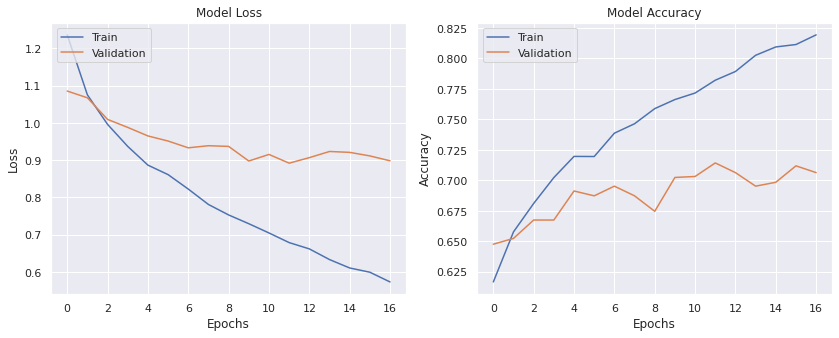

In [ ]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Evaluación del modelo

In [ ]:
#Restore Best Model
model_1.load_weights('/content/drive/My Drive/Files/MCD/Procesamiento y Clasificación de Datos/Proyecto Final/Efficient Net Best Model 31 epochs + Fine Tuning 21 epochs/EfficientNet2_31epochs_Model_bestweights')

In [ ]:
train_loss, train_accu = model_1.evaluate(train_data)
val_loss, val_accu = model_1.evaluate(validation_data)
test_loss, test_accu = model_1.evaluate(test_data)
print("Final Train accuracy = {:.2f} , Validation Accuracy = {:.2f}, Test Accuracy = {:.2f}".format(train_accu*100, val_accu*100, test_accu*100)) 

20/20 [==============================] - 2s 98ms/step - loss: 0.9278 - accuracy: 0.7063
Final Train accuracy = 83.02 , Validation Accuracy = 69.84, Test Accuracy = 70.63


## Matriz de Confusión y Reporte de Clasificación en Set de Prueba

Confusion Matrix
[[45  0  0  1  9  1  0  1  0 13  0  3  0  4  7]
 [ 3 54  0  3  6  2  2  2  1  4  0  3  1  3  0]
 [ 0  0 78  0  0  0  0  0  0  0  1  5  0  0  0]
 [ 1  3  1 63  0  0  6  1  4  1  1  3  0  0  0]
 [ 2  0  0  0 61  1  1  2  2  5  0  1  1  5  3]
 [ 0  2  0  0  1 75  0  1  0  0  0  0  1  2  2]
 [ 1  2  0  5  0  0 63  3  0  0  5  3  2  0  0]
 [ 2  0  1  0  3  0  0 59  5  1  1  4  3  1  4]
 [ 2  2  0  0  1  0  0 10 56  8  0  0  2  3  0]
 [ 3  0  0  0  4  1  0  0  3 52  1  6  1  7  6]
 [ 0  1  1  8  0  0  1  2  1  0 69  1  0  0  0]
 [ 1  3  1  2  0  1  0  4  0  4  3 51  1  2 11]
 [ 0  0  0  1  0  1  4  1  2  0  0  6 66  0  3]
 [ 5  0  0  0  4  1  0  4  4 10  0  3  3 41  9]
 [ 4  1  0  1  1  0  0  2  0  4  0 10  1  3 57]]
Classification Report
                    precision    recall  f1-score   support

           calling       0.65      0.54      0.59        84
          clapping       0.79      0.64      0.71        84
           cycling       0.95      0.93      0.94        84

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

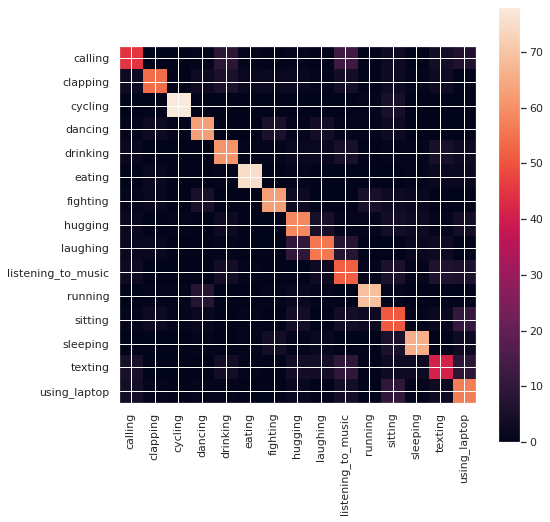

In [ ]:
y_pred = model_1.predict(test_data)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_data.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
%matplotlib inline

cm_test = confusion_matrix(test_data.classes, y_pred)
cm_df=pd.DataFrame(cm_test)
cm_df.to_csv('/content/drive/My Drive/Files/MCD/Procesamiento y Clasificación de Datos/Proyecto Final/EfficientNet_CM.csv',
                   index=False)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())

report=classification_report(test_data.classes, y_pred, target_names=target_names, output_dict=True)
df_classification_report = pd.DataFrame(report).transpose()
df_classification_report.to_csv('/content/drive/My Drive/Files/MCD/Procesamiento y Clasificación de Datos/Proyecto Final/EfficientNet_CReport.csv', index = False)
report=classification_report(test_data.classes, y_pred, target_names=target_names)
print(report)

plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)
plt